In [1]:
import requests as rq
import json
import pandas as pd
import numpy as np
from textwrap import wrap
from matplotlib import pyplot as plt
from TCGA_files import *
#from ensembleAPI import geneinfo, genesinfo
from IPython.display import HTML
from sklearn import metrics
from hsbmpy import *

In [32]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import *

## query many

In [2]:
level = 1
#setup='highlyvariable_colonrectal'
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#label = 'uniq'
L = 3
#labels = ['primary_site', 'disease_type', 'uniq']
labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
#directory = "results/hSBM/%s"%setup
#directory="gtex/hsbm/%s"%setup
#directory = "merged/hsbm"
directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/gtex/hsbm/oversigma_10tissue"
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10
0,GTEX-1117F-1326-SM-5EGHH,GTEX-T6MN-0726-SM-32PML,GTEX-13FHP-0226-SM-5K7WD,GTEX-TSE9-0005-SM-4DXUF,GTEX-17EVP-0726-SM-7EWDX,GTEX-13NYS-0011-R6b-SM-5,GTEX-T8EM-0126-SM-4DM5R,GTEX-ZZPU-0726-SM-5N9C8,GTEX-TSE9-0126-SM-3DB83,GTEX-XQ8I-0926-SM-4BOOF
1,GTEX-VJYA-1326-SM-3GIJC,GTEX-15DCZ-0726-SM-69LOV,GTEX-131XF-0008-SM-664MH,GTEX-NPJ7-0006-SM-3GACR,GTEX-YEC3-0226-SM-5IFJO,GTEX-QDT8-0011-R4A-SM-32,GTEX-QV31-1126-SM-4R1K4,GTEX-XMK1-0326-SM-4B652,GTEX-1C2JI-1826-SM-73KXC,GTEX-12WSC-0126-SM-5EQ4P
2,GTEX-WY7C-0926-SM-3NB34,GTEX-11ZTS-1326-SM-5EQMA,GTEX-WVJS-0008-SM-4MVPC,GTEX-XXEK-0005-SM-4BRWJ,GTEX-PLZ4-0726-SM-2TC6Q,GTEX-13PVQ-0011-R9b-SM-5,GTEX-R55E-0726-SM-48FCZ,GTEX-WFJO-0002-SM-3P61X,GTEX-131XE-1626-SM-5K7VO,GTEX-1211K-2026-SM-5EQ4Z
3,GTEX-WXYG-0926-SM-3NB2O,GTEX-13SLW-2526-SM-62LDQ,GTEX-131XG-0226-SM-5IFG1,GTEX-12WSN-0006-SM-5NQAP,GTEX-131XW-1126-SM-5EGK4,GTEX-13PLJ-0011-R5a-SM-5,GTEX-WHSE-0426-SM-4M1XO,GTEX-WFJO-0626-SM-4LVMC,GTEX-OHPM-0126-SM-2YUN9,GTEX-1B8KE-1126-SM-7EPHI
4,GTEX-139T8-0226-SM-5L3EA,GTEX-ZAJG-0626-SM-5HL8X,GTEX-WWYW-0008-SM-4MVPF,GTEX-XPT6-0006-SM-4B66Q,GTEX-XOT4-1426-SM-4B65T,GTEX-13OW8-0011-R3a-SM-5,GTEX-11TT1-2226-SM-5GU6B,GTEX-139YR-1526-SM-5IFJ1,GTEX-12WSL-2526-SM-5GCNJ,GTEX-1B8KZ-0326-SM-73KY4


In [3]:
#df_files = pd.read_csv("/Users/filippo/Developer/tesi/gtex/files.dat", index_col=[0], header=[0])
#df_files = pd.read_csv("/Users/filippo/Developer/tesi/results/counts/files.dat", index_col=[0], header=[0])
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0])
#df_files.insert(2,'uniq', '')
#for sample in df_files.index.values:
#    row = df_files.loc[sample,:]
#    df_files.at[sample,'uniq']='%s[%s]'%(row['primary_site'],row['disease_type'])
df_files.head()

,primary_site,secondary_site
GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue,Adipose - Subcutaneous
GTEX-111CU-1826-SM-5GZYN,Adipose Tissue,Adipose - Subcutaneous
GTEX-111FC-0226-SM-5N9B8,Adipose Tissue,Adipose - Subcutaneous
GTEX-111VG-2326-SM-5N9BK,Adipose Tissue,Adipose - Subcutaneous
GTEX-111YS-2426-SM-5GZZQ,Adipose Tissue,Adipose - Subcutaneous


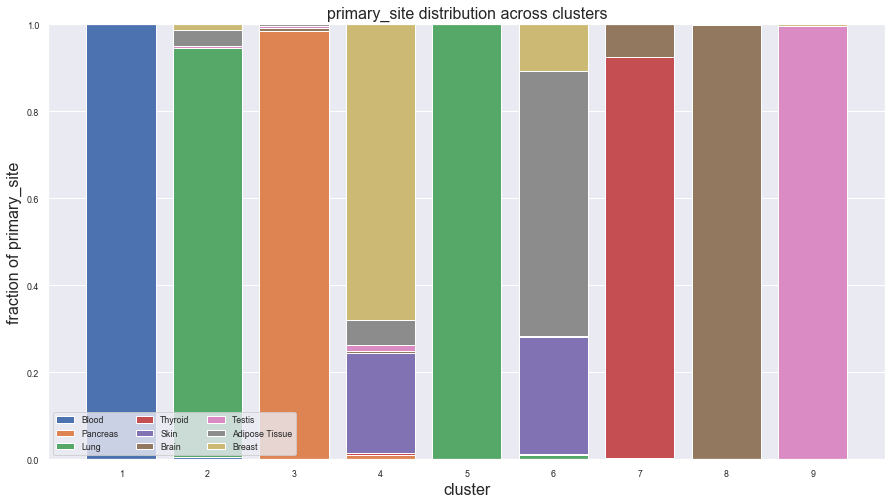

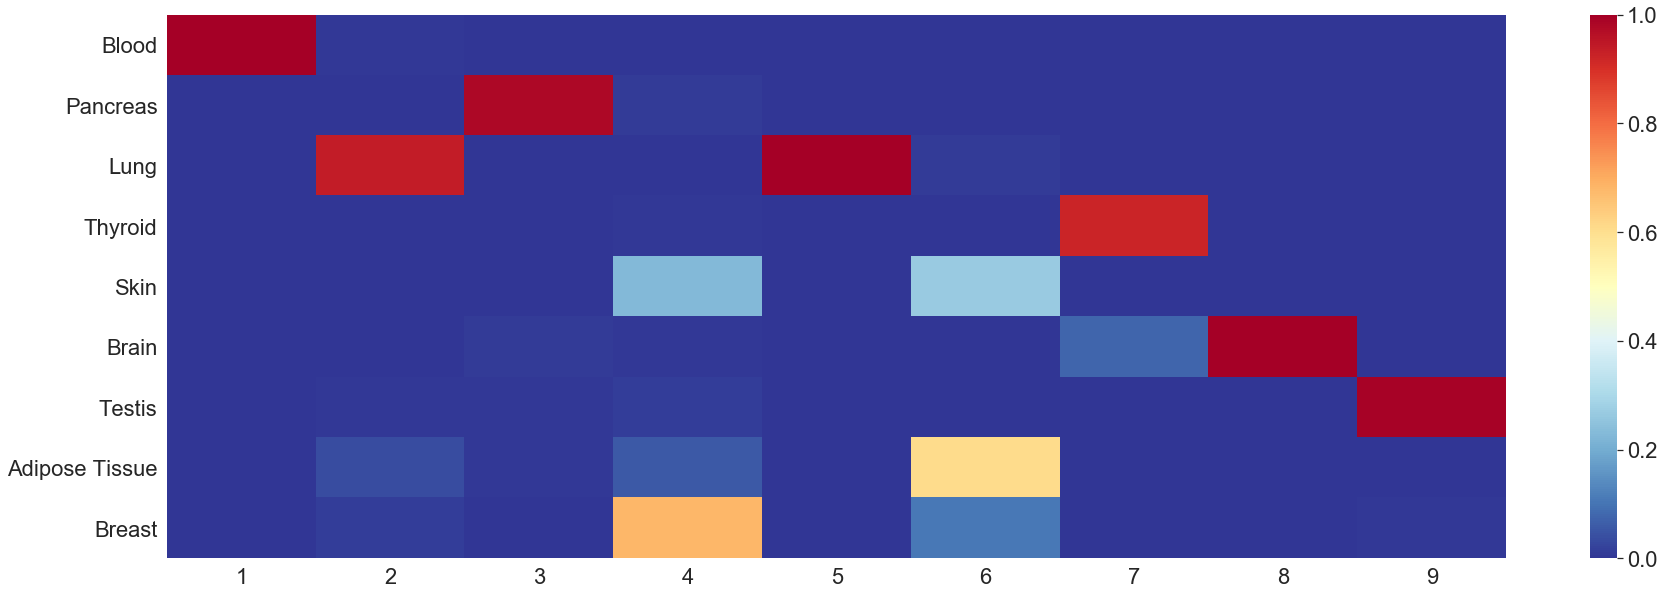

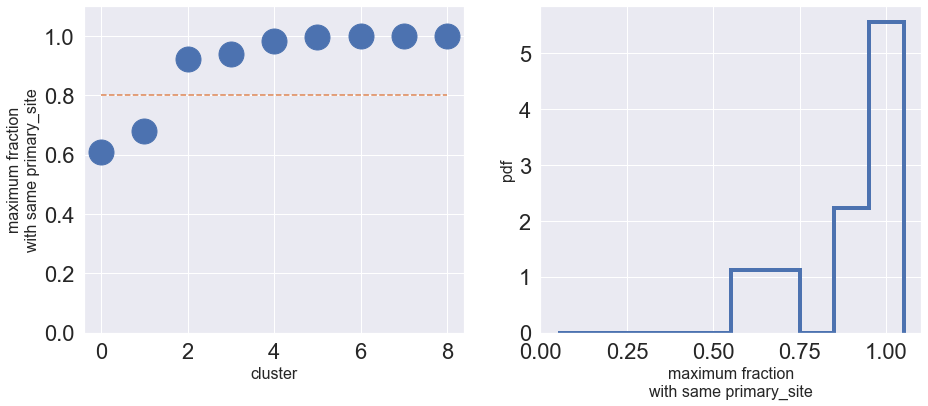

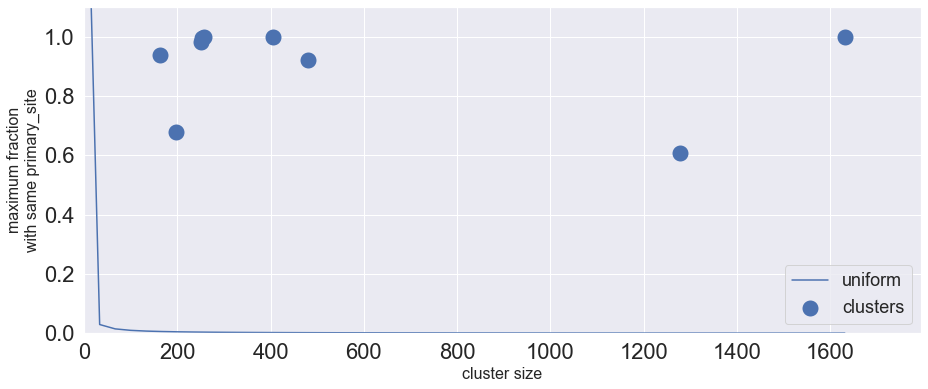

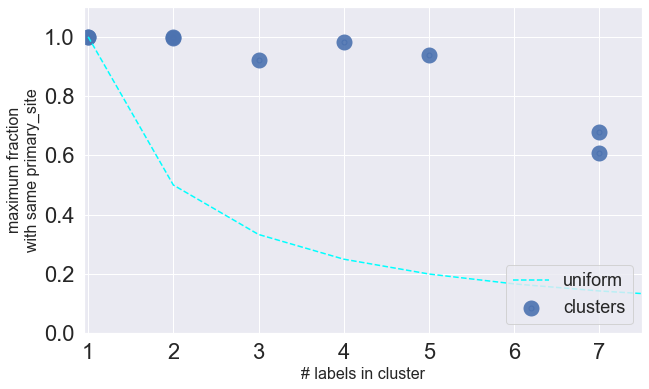

error in GTEX-ZDXO-2426-SM-5S2NJ
error in GTEX-18A6Q-2926-SM-718AR
error in GTEX-16Z82-0011-R6a-SM-7IGLV
error in GTEX-111CU-0526-SM-5EGHK
error in GTEX-111YS-1226-SM-5EGGJ
error in GTEX-1122O-0726-SM-5GIEV
error in GTEX-1128S-0826-SM-5GZZI
must shuffle files


/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


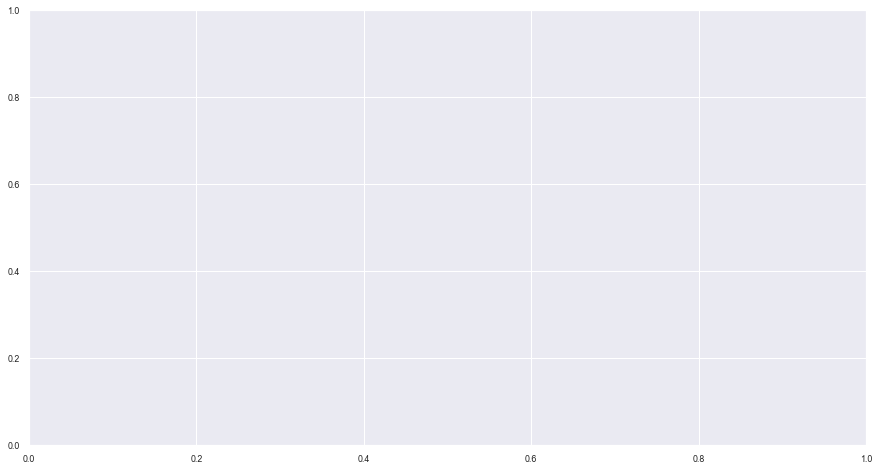

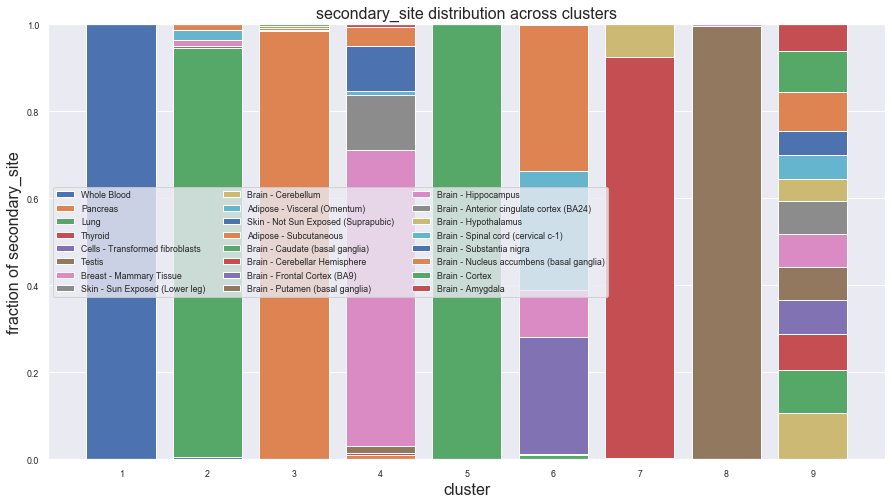

/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


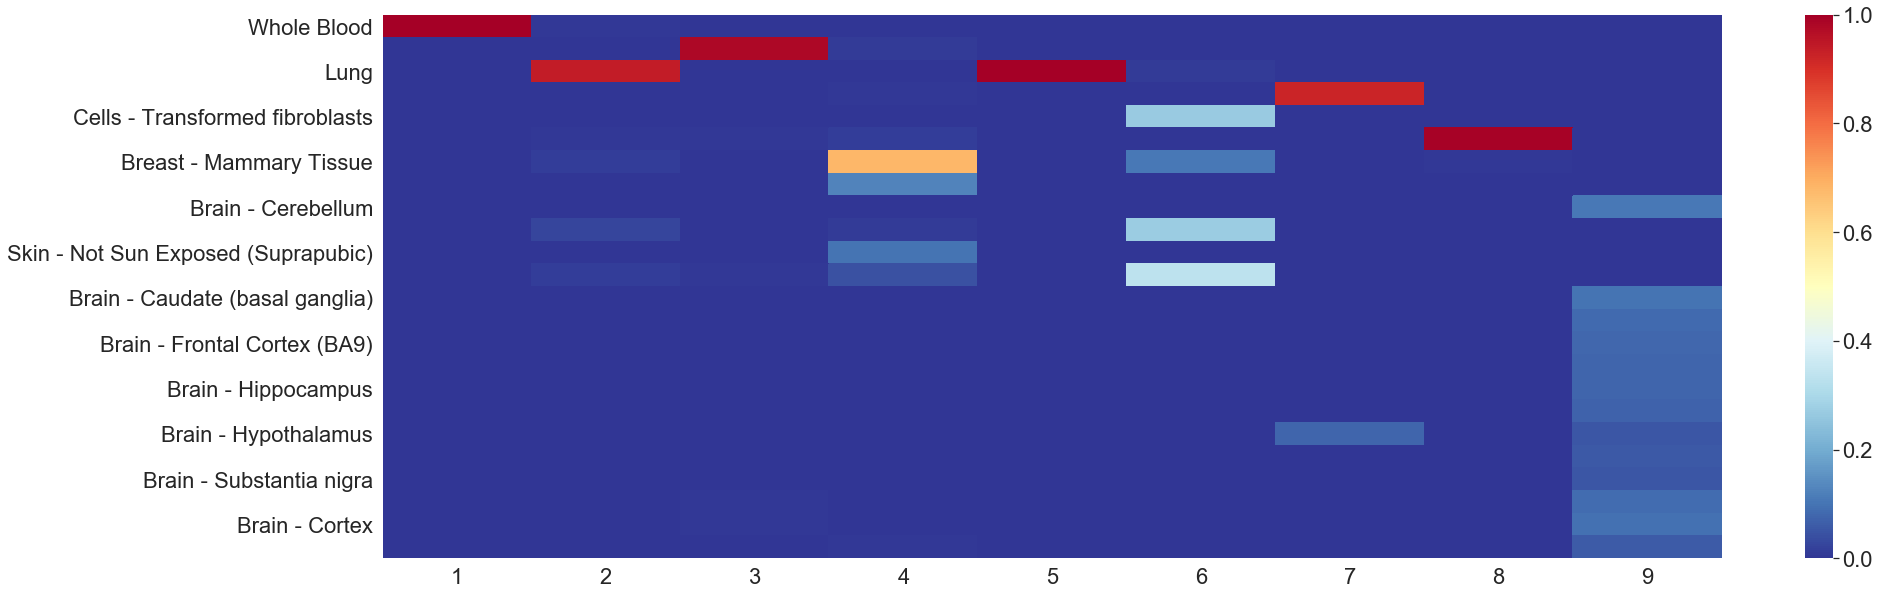

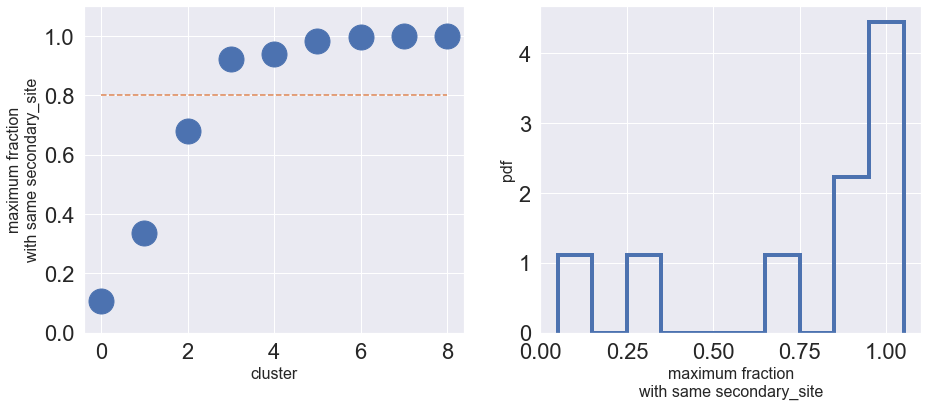

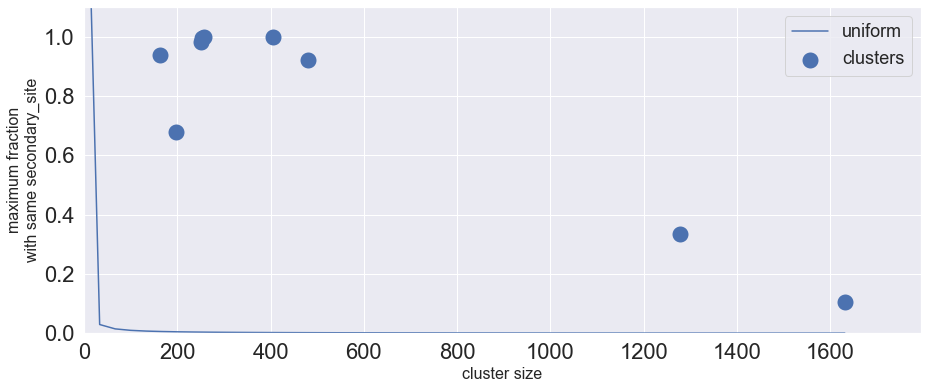

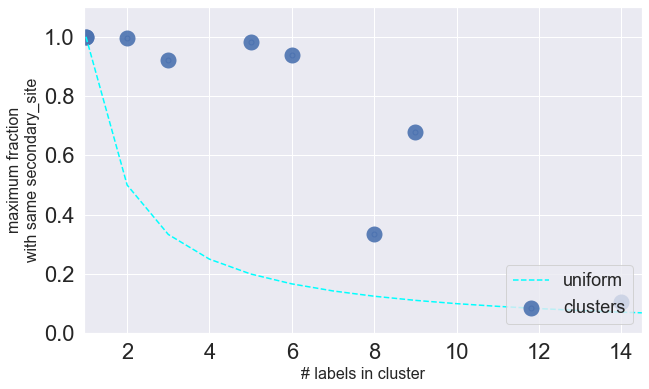

error in GTEX-ZDXO-2426-SM-5S2NJ
error in GTEX-18A6Q-2926-SM-718AR
error in GTEX-16Z82-0011-R6a-SM-7IGLV
error in GTEX-111CU-0526-SM-5EGHK
error in GTEX-111YS-1226-SM-5EGGJ
error in GTEX-1122O-0726-SM-5GIEV
error in GTEX-1128S-0826-SM-5GZZI
must shuffle files


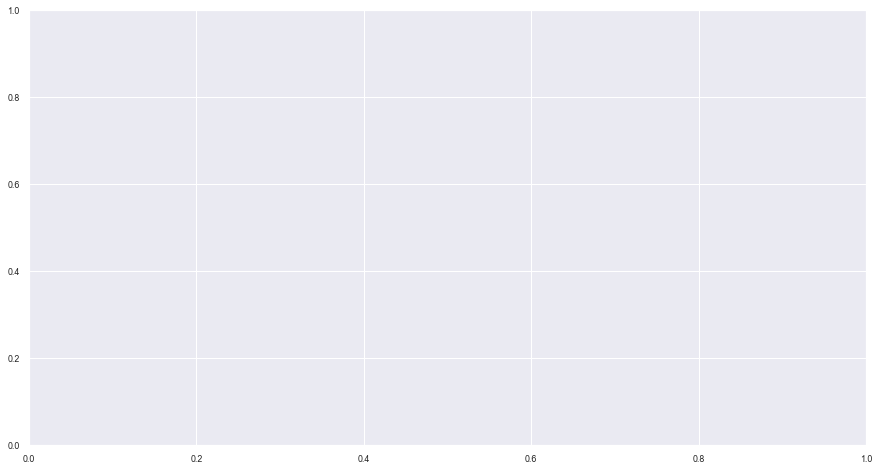

In [35]:
for label in labels:
    for level in np.arange(L+1)[::-1]:
        if level==0:
            continue
        normalise = True
        cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
        fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)
        
        #fsdf = pd.DataFrame(data=fraction_sites)
        #fsdf = fsdf.drop('Other', axis=1)
        #fsdf = fsdf.divide(fsdf.sum(axis=1), axis=0).fillna(0)
        #fraction_sites = fsdf.sort_values(by=fsdf.columns.to_list(), ascending=True).to_dict(orient='list')
        
        clustersinfo = get_clustersinfo(cluster,fraction_sites)
        plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise,algorithm=algorithm)
        make_heatmap(fraction_sites, directory, label, level, normalise=normalise,algorithm=algorithm)
        
        normalise = False
        cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
        fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)
        clustersinfo = get_clustersinfo(cluster,fraction_sites)            
        plot_maximum(clustersinfo,cluster,label,level, directory,algorithm=algorithm)
        plot_maximum_size(clustersinfo,label,level, directory,algorithm=algorithm)
        plot_maximum_label(clustersinfo,label,level, directory,algorithm=algorithm)
        try:
            fraction_sites_shuffle = get_fraction_sites(cluster, pd.read_csv("%s/files.dat.shuf"%directory, index_col=[0]),label=label, normalise=normalise)
            clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
            plot_cluster_composition(fraction_sites_shuffle,directory,level, normalise=False, label=label, shuffled=True)
            plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle,algorithm=algorithm)
            plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
            plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
            plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
        except:
            print("must shuffle files")

In [48]:
def reindex(x):
    i=1
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = df_clusters.dropna().values.reshape(shape[0]*shape[1],)
for level in np.arange(L+1):
    print(level)
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[::-1]], axis=0, inplace=True)
df_labels = df_labels.apply(reindex, axis=0)
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

0
1
2
3


In [6]:
try:
    xl = getclustersizesarray(directory, L)
    with open("%s/clustersizes.txt" % directory, 'w') as f:
        for x in xl:
            f.write("%d\n" % x)
except:
    print("cannot save clustersizes.txt")

try:
    xl = gettopicsizesarray(directory, L)
    with open("%s/topicsizes.txt" % directory, 'w') as f:
        for x in xl:
            f.write("%d\n" % x)
except:
    print("cannot save topicsizes.txt")

In [ ]:
scores = {}
for label in labels:
    scores[label]={
        'h':[],
        'c':[],
        'V':[]
    }
    for l in np.arange(L+1):
        try:
            print(l)
            true_labels, predicted_labels = define_labels(get_cluster_given_l(l, directory), df_files, label=label)
            scores[label]['h'].append(metrics.cluster.homogeneity_score(true_labels, predicted_labels))
            scores[label]['c'].append(metrics.cluster.completeness_score(true_labels, predicted_labels))
            scores[label]['V'].append(metrics.cluster.v_measure_score(true_labels, predicted_labels))
        except:
            pass

In [ ]:
scores['shuffle']={
        'h':[],
        'c':[],
        'V':[]
    }
for l in np.arange(0,L+1):
    print(l)
    _, predicted_labels = define_labels(get_cluster_given_l(l, directory), df_files, label='primary_site')
    true_labels, _ = define_labels(get_cluster_given_l(l,directory), pd.read_csv("%s/files.dat.shuf"%directory, index_col=[0]),label='primary_site')
    scores['shuffle']['h'].append(metrics.cluster.homogeneity_score(true_labels, predicted_labels))
    scores['shuffle']['c'].append(metrics.cluster.completeness_score(true_labels, predicted_labels))
    scores['shuffle']['V'].append(metrics.cluster.v_measure_score(true_labels, predicted_labels))
    

In [ ]:
xl = [len(get_cluster_given_l(li,directory)) for li in np.linspace(1,L,L)]
with open("%s/clustersizes.txt"%directory,'w') as f:
    for x in xl:
        f.write("%d\n"%x)

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,['primary_site'],xl, h=True, c=True, alpha=1)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels,xl)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores.pdf"%(directory))

In [ ]:
h = np.array(scores['primary_site']['h'])
c = np.array(scores['disease_type']['c'])
scores['mixed'] = {
    'h':h,
    'c':c,
    'V':2*h*c/(h+c)
}

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,np.concatenate((labels,['shuffle','mixed'])),xl)
plt.show()
fig.savefig("%s/metric_scores_shuffle.pdf"%(directory))

In [ ]:
scores['hierarchical'] = pd.read_csv("%s/hierarchical.scores"%directory).to_dict(orient='list')

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,np.concatenate((labels,['shuffle','hierarchical'])),xl)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.show()
fig.savefig("%s/metric_scores_hier.pdf"%(directory))

In [ ]:
scores['lda'] = pd.read_csv("%s/lda.scores"%directory).to_dict(orient='list')

In [ ]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,['mixed','hierarchical','shuffle','lda'],xl, lw=2)
plt.show()
fig.savefig("%s/metric_scores_all.pdf"%(directory))

# Benchmark
https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
true_labels = []
predicted_labels = []
for c in cluster:
    print(c)
    for sample in cluster[c]:
        #true_labels.append(getFile(sample)['primary_site'].values[0])
        try:
            true_labels.append(df_files.loc[sample][label])
            predicted_labels.append(c)
        except:
            print("error in %s"%sample)

In [ ]:
_, labels_true = np.unique(true_labels,return_inverse=True)

In [ ]:
series_metrics=pd.Series(name=setup+'__level_%d_%s'%(level,label))
series_metrics['MI']=metrics.cluster.normalized_mutual_info_score(labels_true, predicted_labels, average_method='arithmetic')
series_metrics['Homogeneity']=metrics.cluster.homogeneity_score(labels_true, predicted_labels) 
series_metrics['Completness']=metrics.cluster.completeness_score(labels_true, predicted_labels) 
series_metrics['Vmeasure']=metrics.cluster.v_measure_score(labels_true, predicted_labels)
series_metrics['Fowlkes-Mallows']=metrics.cluster.fowlkes_mallows_score(labels_true,predicted_labels)
series_metrics['AdjustedRandIndex']=metrics.cluster.adjusted_rand_score(labels_true,predicted_labels)

In [ ]:
series_metrics

In [ ]:
#df_metrics = pd.DataFrame(columns=['AdjustedRandIndex','MI','Homogeneity','Completness','Vmeasure','Fowlkes-Mallows'])

In [ ]:
try:
    df_metrics.append(series_metrics, ignore_index=False, verify_integrity=True).to_csv("results/hSBM/metrics.csv", index=True,header=True)
except:
    raise

In [ ]:
df_metrics = pd.read_csv("results/hSBM/metrics.csv", index_col=[0],header=[0])
df_metrics.sort_values(by=['MI','Homogeneity'], ascending=False, axis=0, inplace=True)
df_metrics.round(decimals=2)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(24, 20)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = pd.plotting.table(ax, df_metrics.round(decimals=2), loc='upper right', colWidths=[0.12]*len(df_metrics.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1, 2) # change size table
plt.savefig('results/hSBM/metrics.pdf', transparent=True)

In [ ]:
metrics.cluster.contingency_matrix(true_labels, predicted_labels)

In [ ]:
df_files[df_files['primary_site']=='Brain']